In [1]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [2]:
import dask_ml
print(dask_ml.__file__)
from distributed import Client
client = Client()
client

/Users/scott/Developer/stsievert/dask-ml/dask_ml/__init__.py


Client Scheduler: tcp://127.0.0.1:62424 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


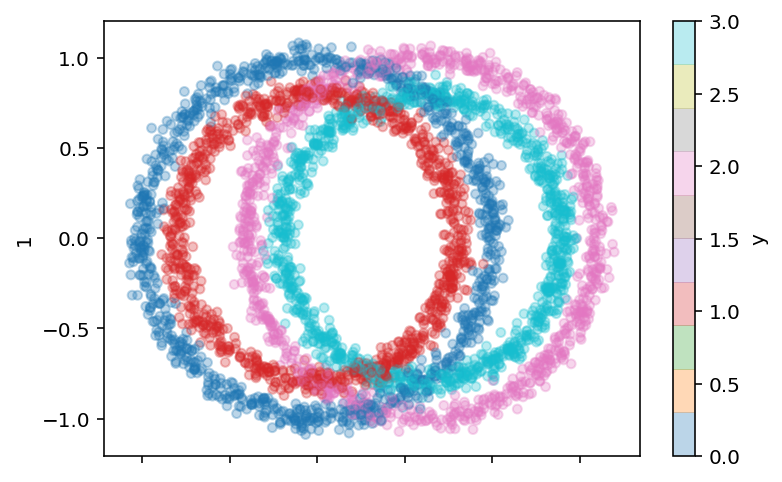

In [3]:
from sklearn.datasets import make_circles
import numpy as np
import pandas as pd

X1, y1 = make_circles(n_samples=30_000, random_state=0, noise=0.04)
X2, y2 = make_circles(n_samples=30_000, random_state=1, noise=0.04)
X2[:, 0] += 0.6
X_info = np.concatenate((X1, X2))
y = np.concatenate((y1, y2 + 2))

df = pd.DataFrame(X_info)
df["y"] = y
df.sample(4_000).plot.scatter(x=0, y=1, c="y", cmap="tab10", alpha=0.3)


In [4]:
# add random features

from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_random_state

rng = check_random_state(42)
random_feats = rng.uniform(-1, 1, size=(X_info.shape[0], 4))
X_ = np.hstack((X_info, random_feats))

X = X_
# transform = PolynomialFeatures(degree=4)
# X = transform.fit_transform(X_)
X.shape

(60000, 6)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=int(10e3), random_state=42)


In [6]:
import numpy as np
assert np.unique(y).tolist() == [0, 1, 2, 3]

In [7]:
X_test.shape

(10000, 6)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from dask_ml.model_selection import HyperbandSearchCV

model = MLPClassifier()

params = {
    "hidden_layer_sizes": [(24, ),
                           (12, ) * 2,
                           (6, ) * 4,
                           (4, ) * 6,
                           (12, 6, 3, 3)],
    "alpha": np.logspace(-6, -3, num=1000),  # cnts
    "batch_size": [32, 64, 128, 256, 512],  # 5
    "learning_rate": ["constant", "invscaling"],
    "learning_rate_init": np.logspace(-4, -2, num=1000), # cnts
    "power_t": np.linspace(0.1, 0.9, num=1000), # cnts
    "momentum": np.linspace(0, 1, num=1000),  # cnts
    "nesterovs_momentum": [True],  # 1
    "n_iter_no_change": [np.inf],
    "solver": ["sgd"],
    "activation": ["relu"],
    "random_state": np.arange(10_000),
}

/Users/scott/anaconda3/lib/python3.6/site-packages/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [10]:
epochs = 80
n_params = 300

n = len(X_train)
max_iter = n_params
chunks = epochs * n // n_params
max_iter, chunks

(300, 13333)

In [11]:
from dask_ml.model_selection import train_test_split
import dask.array as da
X_train = da.from_array(X_train, chunks=chunks)
y_train = da.from_array(y_train, chunks=chunks)
X_train

dask.array<array, shape=(50000, 6), dtype=float64, chunksize=(13333, 6)>

In [12]:
X_train.chunks

((13333, 13333, 13333, 10001), (6,))

In [13]:
classes = da.unique(y_train).compute()
print(classes)
y_train

[0 1 2 3]


dask.array<array, shape=(50000,), dtype=int64, chunksize=(13333,)>

In [14]:
import warnings

search = HyperbandSearchCV(
    model,
    params,
    max_iter=max_iter,
    random_state=403,
    patience=2,
    tol=np.nan,
    aggressiveness=4,
)

search.fit(X_train, y_train, classes=classes)
print(pd.DataFrame(search.history_)["partial_fit_calls"].max())
assert pd.DataFrame(search.history_)["partial_fit_calls"].max() == max_iter

300


In [15]:
import msgpack
# This uses aggressiveness=4
# today = "2019-06-22-wo-priority-v1"
today = "out/2019-06-25-with-priority-v4"

def _get_history(search):
    params = {k: v for k, v in search.get_params().items()
              if "estimator" not in k and k != "parameters"
    }
    params["best_score_"] = search.best_score_
    est_params = {"est__" + k: v for k, v in search.history_[0]["params"].items()}
    est_params["est__random_state"] = int(est_params["est__random_state"])
    hist = [{k: v for k, v in h.items() if k != "params"} for h in search.history_]
    out = [{**params, **h, **est_params} for h in hist]
    return out

hist = _get_history(search)

import msgpack
with open(f"{today}-history.msgpack", "wb") as f:
    msgpack.dump(hist, f)

import json
with open(f"{today}-basics.msgpack", "wb") as f:
    info = {k: getattr(search, k) for k in ["best_score_", "best_params_"]}
    if "random_state" in info["best_params_"]:
        info["best_params_"].pop("random_state")
    msgpack.dump(info, f)

5633